In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *

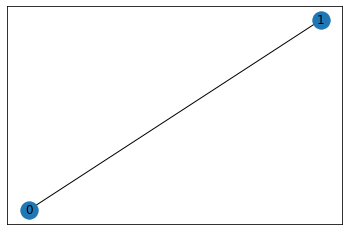

In [2]:
V = np.arange(0,2,1)
E =[(0,1,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

nx.draw_networkx(G)

In [3]:
from qaoa import *

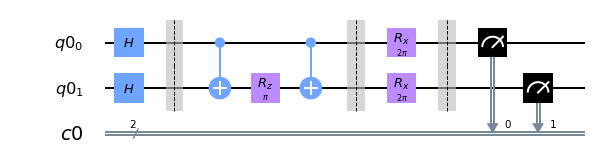

In [4]:
createCircuit_MaxCut(np.array((np.pi,np.pi)),G,1,True).draw(output='mpl')

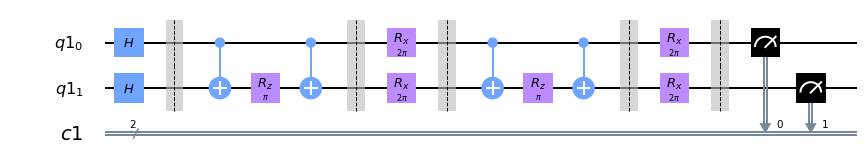

In [5]:
createCircuit_MaxCut(np.array((np.pi,np.pi,np.pi,np.pi)),G,2,True).draw(output='mpl')

In [6]:
listcosts_MaxCut(G)

({'00': 0.0, '01': 1.0, '10': 1.0, '11': 0.0}, 1.0, ['01', '10'])

In [12]:
def expectationValue(data,G):
    E=[]
    V = list(G.nodes)
    num_qubits = len(V)
    for item in range(0,len(data.results)):
        shots = data.results[item].shots
        counts = data.results[item].data.counts
        E.append(0)
        for key in list(counts.__dict__.keys()):
            c=getattr(counts, key)#number of counts
            binstring="{0:b}".format(int(key,0)).zfill(num_qubits)
            y=[int(i) for i in binstring]
            E[item] += cost_MaxCut(y,G)*c/shots
    return E

In [14]:
Aer.backends()
backend_sim = Aer.get_backend('qasm_simulator')

In [15]:
from scipy import optimize as opt

In [24]:
def getval(x, backend, depth=1, noisemodel=None):
    j = execute(createCircuit_MaxCut(x,G,depth), backend, noise_model=noisemodel, shots=1024*2*2*2)
    val=expectationValue(j.result(),G)
    return -val[0]

In [25]:
out=opt.minimize(getval, x0=(1, 1), method='Nelder-Mead',\
                 args=(backend_sim,1,None),\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 22
         Function evaluations: 43


In [26]:
j = execute(createCircuit_MaxCut(out.x,G,1), backend_sim, shots=1024*2*2*2)

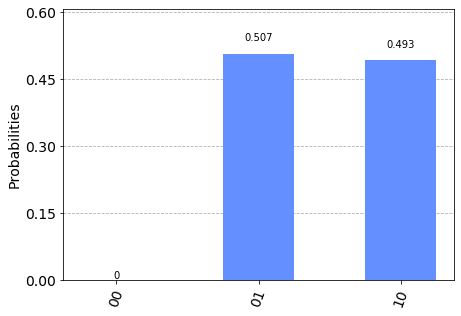

In [27]:
plot_histogram(j.result().get_counts())

In [33]:
out=opt.minimize(getval, x0=(0.5, 1, 0.5, 0.5), method='Nelder-Mead',\
                 args=(backend_sim,2,None),\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.949585
         Iterations: 51
         Function evaluations: 97


In [34]:
j = execute(createCircuit_MaxCut(out.x,G,2), backend_sim, shots=1024*2*2*2)

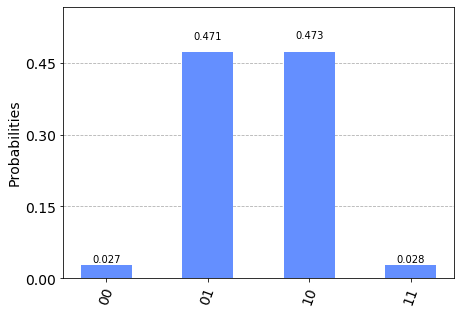

In [35]:
plot_histogram(j.result().get_counts())